In [38]:
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns, numpy as np
import seaborn as sns
import scipy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as plt
import matplotlib as mpl
import io
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import label_binarize,LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Perceptron
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.datasets import make_regression
from sklearn.datasets import make_classification
from sklearn.datasets import load_iris
from sklearn.datasets import fetch_olivetti_faces
from sklearn import svm, datasets
from sklearn import clone
from scipy import stats
from scipy import special, optimize

- overall : 감시취약면적, 감시취약지수(cctv_idx), 격자가중치w1 가 있다
- w2 : 행정동별 단독주택
- w3 : 행정동별 여성주가구비율

## w2-3의 데이터 출처
https://data.seoul.go.kr/dataList/10595/S/2/datasetView.do

https://data.seoul.go.kr/dataList/10585/S/2/datasetView.do

## 목표
- 아래 지수에 대한 scoring 을 위한 정규화
- 정규화 후 상관계수 출력
- 동 별 분류 모델링
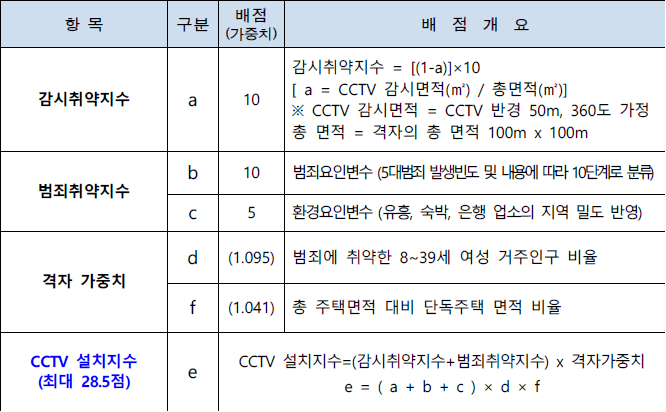

# 최종 테이블
- 2020/12/14 11:40 - overall_merge_w1

## Grade2_env = (유흥밀도+숙박밀도_금융밀도)*5 으로써 1~10사이의 값을가짐.

In [79]:
overall = pd.read_csv('행정동_OVERALL(cctv_by_emd-idx,v1,v2,w1)_1208.csv')

In [80]:
w2 = pd.read_csv('행정동별_단독주택_w2.csv')

In [81]:
w3 = pd.read_csv('행정동별_여성주가구비율_w3.csv')

In [82]:
overall.head(5)

,BASE_YEAR,ADM_DR_CD,ADM_DR_NM,cctv_area,cctv_idx,금융업소갯,숙박업소갯,유흥업소갯,max뉴연번,grade1_cri,...,val_29,val_19,val_16,val_39,sum_women,w1,가중치_w1(w1*3),.75 이상이면 1.095 이하면 1,w1_women,count_1
0,2018,1115051,목1동,193887,8.061,11,3,103,13599,4,...,126,52,77,192,602,0.25341,0.76023,1.095,1.095,179
1,2018,1115052,목2동,531772,4.682,3,2,23,13600,4,...,85,31,40,81,221,0.39560,1.18680,1.095,1.095,133
2,2018,1115053,목3동,329554,6.704,3,1,40,13604,4,...,65,14,12,145,221,0.40000,1.20000,1.095,1.095,80
3,2018,1115054,목4동,377440,6.226,2,0,30,13607,4,...,93,33,40,56,237,0.34247,1.02741,1.095,1.095,82
4,2018,1115057,신월1동,349643,6.504,2,1,46,13601,4,...,38,11,10,45,93,0.28497,0.85491,1.095,1.095,88


In [83]:
w2.head(1)

,기간,자치구,동,합계,주택합계,단독주택,단독주택 전처리 (전체단독주택수 : 행정동 단독주택수 = 전체합계 : 행정동 전체합계),w2,다가구주택,영업겸용,아파트,연립주택,다세대주택,비거주용건물내주택
0,2015,양천구,목1동,7769,127,17,"1,438(F2)*127(E3) / 9907(E2)",NaN,74,36,"7,370",42,197,33


In [84]:
w3.head(3)

,기간,자치구,동,일반가구,여성가구주 가구,여성가구주가구비율,value*(3/100),0.7 이상이면 1.041 이하면 1
0,2010,양천구,소계,"154,239","36,561",23.7,0.711,1.041
1,2010,양천구,목1동,"9,463","1,557",16.5,0.495,1.000
2,2010,양천구,목2동,"9,934","2,547",25.6,0.768,1.041


In [85]:
# merge 하기 위해 column 이름 변경 overall의 행정동 이름 변경 
overall.rename(columns= {'ADM_DR_NM' : '행정동'},inplace = True)
w2.rename(columns= {'동' : '행정동'},inplace = True)
w3.rename(columns= {'동' : '행정동'},inplace = True)

In [86]:
overall[('행정동')][1]

'목2동'

In [87]:
w2[('행정동')][1]

'목2동'

In [88]:
w3[('행정동')][1]

'목1동'

In [89]:
overall_merge = pd.merge(overall,w2,on = ['행정동'])

In [90]:
overall_merge = pd.merge(overall_merge,w3, on = ['행정동'])

In [91]:
overall_merge[1:5]

,BASE_YEAR,ADM_DR_CD,행정동,cctv_area,cctv_idx,금융업소갯,숙박업소갯,유흥업소갯,max뉴연번,grade1_cri,...,연립주택,다세대주택,비거주용건물내주택,기간_y,자치구_y,일반가구,여성가구주 가구,여성가구주가구비율,value*(3/100),0.7 이상이면 1.041 이하면 1
1,2018,1115052,목2동,531772,4.682,3,2,23,13600,4,...,514,"5,398",75,2010,양천구,"9,934","2,547",25.6,0.768,1.041
2,2018,1115053,목3동,329554,6.704,3,1,40,13604,4,...,141,"3,227",49,2010,양천구,"7,466","2,182",29.2,0.876,1.041
3,2018,1115054,목4동,377440,6.226,2,0,30,13607,4,...,300,"3,096",79,2010,양천구,"8,445","2,008",23.8,0.714,1.041
4,2018,1115057,신월1동,349643,6.504,2,1,46,13601,4,...,443,"2,662",107,2010,양천구,"8,574","2,351",27.4,0.822,1.041


In [92]:
overall_merge.columns

Index(['BASE_YEAR', 'ADM_DR_CD', '행정동', 'cctv_area', 'cctv_idx', '금융업소갯',
       '숙박업소갯', '유흥업소갯', 'max뉴연번', 'grade1_cri', 'maxX', 'maxY', 'count',
       'NUMPOINT', '금융밀도', '숙박밀도', '유흥밀도', 'grade2_env', 'val_200', 'val_13',
       'val_29', 'val_19', 'val_16', 'val_39', 'sum_women', 'w1',
       '가중치_w1(w1*3)', '.75 이상이면 1.095 이하면 1', 'w1_women', 'count_1', '기간_x',
       '자치구_x', '합계', '주택합계', '단독주택',
       '단독주택 전처리 (전체단독주택수 : 행정동 단독주택수 = 전체합계 : 행정동 전체합계)', 'w2', '다가구주택',
       '영업겸용', '아파트', '연립주택', '다세대주택', '비거주용건물내주택', '기간_y', '자치구_y', '일반가구',
       '여성가구주 가구', '여성가구주가구비율', 'value*(3/100)', '0.7 이상이면 1.041 이하면 1'],
      dtype='object')

- 감시취약지수 : a
- 범죄취약지수 - 범죄요인변수 : b
- 범죄취약지수 - 환경요인변수 : c

In [93]:
overall_merge.rename(columns = {'cctv_idx' : 'a'},inplace = True)
overall_merge.rename(columns = {'grade1_cri' : 'b'},inplace = True)
overall_merge.rename(columns = {'유흥밀도' : 'c'},inplace = True)

In [94]:
overall_merge['a'][0:5]

0    8.061
1    4.682
2    6.704
3    6.226
4    6.504
Name: a, dtype: float64

## Min Max 를 사용한 정규화 결과

In [95]:
# w1에 대한 정규화를 진행할 것임.
mnscaler = MinMaxScaler()

In [96]:
df1 = pd.DataFrame(overall_merge.loc[:,'행정동'], columns = ['행정동'])

In [97]:
df2 = pd.DataFrame(mnscaler.fit_transform(overall_merge.loc[:, 'sum_women':'w1']), columns = ['sum_women','w1'])

In [98]:
w1_df = pd.DataFrame(overall_merge.loc[:,'w1'], columns = ['w1'])

In [99]:
w1_df

,w1
0,0.25341
1,0.39560
2,0.40000
3,0.34247
4,0.28497
5,0.43697
6,0.28497
7,0.20000
8,0.22872
9,0.22439


In [100]:
overall_merge_scaling = pd.concat([df1,df2],axis=1)
print(overall_merge_scaling)

     행정동  sum_women        w1
0    목1동   1.000000  0.178033
1    목2동   0.251473  0.652000
2    목3동   0.251473  0.666667
3    목4동   0.282908  0.474900
4   신월1동   0.000000  0.283233
5   신월2동   0.153242  0.789900
6   신월3동   0.015717  0.283233
7   신월4동   0.155206  0.000000
8   신월5동   0.041257  0.095733
9   신월6동   0.271120  0.081300
10  신월7동   0.163065  0.070367
11  신정1동   0.223969  0.248833
12  신정2동   0.223969  0.163433
13  신정3동   0.367387  0.789900
14  신정6동   0.298625  0.158567
15  신정7동   0.212181  0.201033
16   목5동   0.253438  1.000000
17  신정4동   0.078585  0.789900


## Z_score 정규화(소수점까지나와서)

In [116]:
from sklearn.preprocessing import StandardScaler

In [117]:
overall_merge_z = overall_merge
stdscaler = StandardScaler()

In [118]:
df1_z = pd.DataFrame(overall_merge_z.loc[:,'행정동'], columns = ['행정동'])
df2_z = pd.DataFrame(stdscaler.fit_transform(overall_merge_z.loc[:, 'sum_women':'w1']), columns = ['sum_women','w1'])

In [119]:
overall_merge_z_scaling = pd.concat([df1,df2],axis=1)
print(overall_merge_z_scaling)

     행정동  sum_women        w1
0    목1동   1.000000  0.178033
1    목2동   0.251473  0.652000
2    목3동   0.251473  0.666667
3    목4동   0.282908  0.474900
4   신월1동   0.000000  0.283233
5   신월2동   0.153242  0.789900
6   신월3동   0.015717  0.283233
7   신월4동   0.155206  0.000000
8   신월5동   0.041257  0.095733
9   신월6동   0.271120  0.081300
10  신월7동   0.163065  0.070367
11  신정1동   0.223969  0.248833
12  신정2동   0.223969  0.163433
13  신정3동   0.367387  0.789900
14  신정6동   0.298625  0.158567
15  신정7동   0.212181  0.201033
16   목5동   0.253438  1.000000
17  신정4동   0.078585  0.789900


overall_merge_stdscaling = pd.concat([df1_z,df2_z],axis=1)
print(overall_merge_stdscaling)

## 정규화는 MinMax 정규화를 채택한다
- min max 1~0 사이의 값의 중간은 0.5 이므로
- 0.5 이상이면 1.095 이하면 1

In [101]:
overall_merge_scaling[1:19]

,행정동,sum_women,w1
1,목2동,0.251473,0.652000
2,목3동,0.251473,0.666667
3,목4동,0.282908,0.474900
4,신월1동,0.000000,0.283233
5,신월2동,0.153242,0.789900
6,신월3동,0.015717,0.283233
7,신월4동,0.155206,0.000000
8,신월5동,0.041257,0.095733
9,신월6동,0.271120,0.081300
10,신월7동,0.163065,0.070367


In [102]:
overall_merge_scaling.rename(columns = {'w1':'w1_mn'},inplace = True)

In [103]:
overall_merge_scaling[1:2]

,행정동,sum_women,w1_mn
1,목2동,0.251473,0.652


In [104]:
abc = np.where(overall_merge_scaling['w1_mn'] > 0.5,1.091,1)

In [106]:
abc

0     False
1      True
2      True
3     False
4     False
5      True
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13     True
14    False
15    False
16     True
17     True
Name: w1_mn, dtype: bool

In [105]:
overall_merge_scaling['w1_score'] = np.where(overall_merge_scaling['w1_mn'] > 0.5,1.091,1)

In [107]:
print(abc)

0     False
1      True
2      True
3     False
4     False
5      True
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13     True
14    False
15    False
16     True
17     True
Name: w1_mn, dtype: bool


## MinMax 정규화를 채택후 w1의 가중치를 0~1사이의 값에서 0.5보다 클 경우 1.091로 설정 0.5 이하는 1으로 설정

In [ ]:
overall_merge_scaling['w1_score'] = np.where(overall_merge_scaling['w1_mn'] > 0.5,1.091,1)

In [109]:
overall_merge_scaling

,행정동,sum_women,w1_mn,w1_score
0,목1동,1.000000,0.178033,1.000
1,목2동,0.251473,0.652000,1.091
2,목3동,0.251473,0.666667,1.091
3,목4동,0.282908,0.474900,1.000
4,신월1동,0.000000,0.283233,1.000
5,신월2동,0.153242,0.789900,1.091
6,신월3동,0.015717,0.283233,1.000
7,신월4동,0.155206,0.000000,1.000
8,신월5동,0.041257,0.095733,1.000
9,신월6동,0.271120,0.081300,1.000


- 행정동 까지 하고 전체데이터 merge 하였음.
- w2,w3 동일하게 scaling 


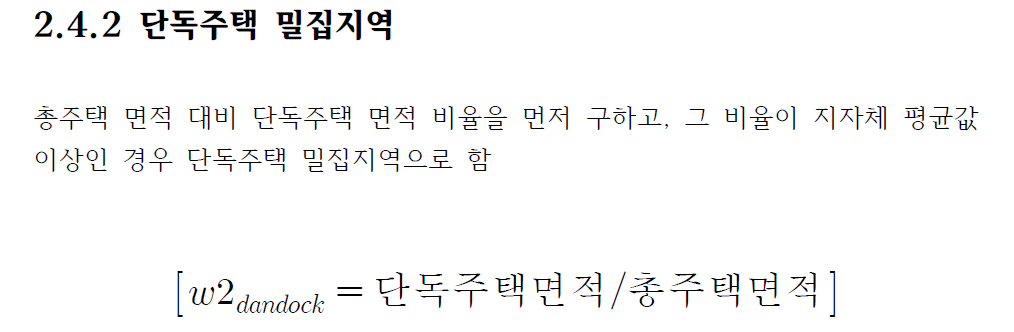

- 테이블에 결측치가 보인다. 결측치를 여러가지 방식으로 구해본다.
#### 결측치 대체
1) 평균값
2) 중위수
3) row wise deletion (Na값의 행을 취급하지 않는다.)

In [ ]:
overall_merge_w1 = pd.merge(overall_merge,overall_merge_scaling, on = ['행정동'])

In [120]:
w2

,기간,자치구,행정동,합계,주택합계,단독주택,단독주택 전처리 (전체단독주택수 : 행정동 단독주택수 = 전체합계 : 행정동 전체합계),w2,다가구주택,영업겸용,아파트,연립주택,다세대주택,비거주용건물내주택
0,2015,양천구,목1동,7769,127,17,"1,438(F2)*127(E3) / 9907(E2)",NaN,74,36,"7,370",42,197,33
1,2015,양천구,목2동,9200,662,79,NaN,NaN,460,123,"2,551",514,"5,398",75
2,2015,양천구,목3동,5918,674,94,NaN,NaN,455,125,"1,827",141,"3,227",49
3,2015,양천구,목4동,6990,698,45,NaN,NaN,492,161,"2,817",300,"3,096",79
4,2015,양천구,목5동,12391,0,0,NaN,NaN,X,X,"12,390",X,X,X
5,2015,양천구,소계,134097,9907,1438,NaN,NaN,"6,532","1,937","83,827","4,459","34,948",956
6,2015,양천구,신월1동,5652,1179,104,NaN,NaN,857,218,"1,261",443,"2,662",107
7,2015,양천구,신월2동,7244,305,12,NaN,NaN,213,80,"3,790",933,"2,161",55
8,2015,양천구,신월3동,3972,1163,141,NaN,NaN,866,156,820,180,"1,765",44
9,2015,양천구,신월4동,5942,194,16,NaN,NaN,108,70,"3,415",473,"1,836",24


### w2(단독주택 밀집지역)
- w2_usecol : 오직 가중치 산출에 필요한 컬럼만 출력 - '행정동','합계','주택합계','단독주택'
- w2 상관분석에 필요한 컬럼 -'행정동','합계','주택합계','단독주택', '다가구주택' '영업겸용','아파트','연립주택','다세대주택','비거주용건물내주택'

In [130]:
w2_usecol = w2.loc[:, ['행정동','합계','주택합계','단독주택']]

In [151]:
w2_usecol_fill_mean = w2_usecol.fillna(w2_usecol.mean()) # Na 값을 평균으로 대체하고

In [154]:
w2_usecol_fill_mean = w2_usecol.replace(0,w2_usecol.mean())#0 값을 평균으로 대체한다

In [155]:
w2_usecol_fill_mean = round(w2_usecol_fill_mean,0) #반올림

In [156]:
w2_usecol_fill_mean

,행정동,합계,주택합계,단독주택
0,목1동,7769,127.0,17.0
1,목2동,9200,662.0,79.0
2,목3동,5918,674.0,94.0
3,목4동,6990,698.0,45.0
4,목5동,12391,1043.0,152.0
5,소계,134097,9907.0,1438.0
6,신월1동,5652,1179.0,104.0
7,신월2동,7244,305.0,12.0
8,신월3동,3972,1163.0,141.0
9,신월4동,5942,194.0,16.0


### W2 구하기

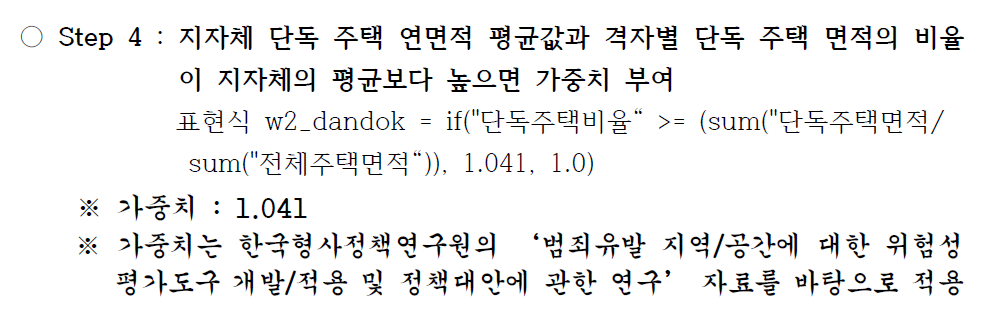

In [157]:
w2_usecol_fill_mean['w2'] = w2_usecol_fill_mean['단독주택']/w2_usecol_fill_mean['주택합계']

In [159]:
w2_usecol_fill_mean[1:2]

,행정동,합계,주택합계,단독주택,w2
1,목2동,9200,662.0,79.0,0.119335


In [168]:
# 단독주택비율 (0~1사이의 값 Minmax정규화)
# dandok_ratio
mnscaler = MinMaxScaler()

In [169]:
df1_dandok = pd.DataFrame(w2_usecol_fill_mean.loc[:,'행정동'],columns = ['행정동'])

In [170]:
df2_dandok = pd.DataFrame(mnscaler.fit_transform(w2_usecol_fill_mean.loc[:,'주택합계':'단독주택']), columns = ['주택합계_ratio','단독주택_ratio'])

In [171]:
w2_usecol_fill_mean_scaling = pd.concat([df1_dandok,df2_dandok],axis=1)

In [172]:
print(w2_usecol_fill_mean_scaling)

     행정동  주택합계_ratio  단독주택_ratio
0    목1동    0.006905    0.006988
1    목2동    0.061231    0.050314
2    목3동    0.062449    0.060797
3    목4동    0.064886    0.026555
4    목5동    0.099919    0.101328
5     소계    1.000000    1.000000
6   신월1동    0.113729    0.067785
7   신월2동    0.024980    0.003494
8   신월3동    0.112104    0.093641
9   신월4동    0.013708    0.006289
10  신월5동    0.046101    0.023760
11  신월6동    0.078290    0.322152
12  신월7동    0.000000    0.000000
13  신정1동    0.024472    0.008386
14  신정2동    0.028026    0.027254
15  신정3동    0.133936    0.164221
16  신정4동    0.137287    0.049616
17  신정6동    0.099919    0.101328
18  신정7동    0.002031    0.018169


In [173]:
w2_merged = pd.merge(w2_usecol_fill_mean,w2_usecol_fill_mean_scaling,on = ['행정동'])

In [174]:
w2_merged

,행정동,합계,주택합계,단독주택,w2,주택합계_ratio,단독주택_ratio
0,목1동,7769,127.0,17.0,0.133858,0.006905,0.006988
1,목2동,9200,662.0,79.0,0.119335,0.061231,0.050314
2,목3동,5918,674.0,94.0,0.139466,0.062449,0.060797
3,목4동,6990,698.0,45.0,0.064470,0.064886,0.026555
4,목5동,12391,1043.0,152.0,0.145733,0.099919,0.101328
5,소계,134097,9907.0,1438.0,0.145150,1.000000,1.000000
6,신월1동,5652,1179.0,104.0,0.088210,0.113729,0.067785
7,신월2동,7244,305.0,12.0,0.039344,0.024980,0.003494
8,신월3동,3972,1163.0,141.0,0.121238,0.112104,0.093641
9,신월4동,5942,194.0,16.0,0.082474,0.013708,0.006289


#### - w2_by_ratio : 단독주택 ratio > 주택합계 ratio 이면 1.041 그렇지 않으면 1
#### - w2_by_mean : w2값의 평균보다 높으면 1.041 그렇지 않으면 1
##### - 가중치의 평균값 : 0.149

In [179]:
w2_merged['w2_by_ratio'] = np.where(w2_merged['단독주택_ratio'] > w2_merged['주택합계_ratio'],1.041,1)

In [186]:
w2_merged['w2'].mean()

0.14929999032211083

In [187]:
w2_merged['w2_by_mean'] = np.where(w2_merged['w2'] > w2_merged['w2'].mean(),1.041,1)

In [188]:
w2_merged

,행정동,합계,주택합계,단독주택,w2,주택합계_ratio,단독주택_ratio,w2_by_ratio,w2_by_mean
0,목1동,7769,127.0,17.0,0.133858,0.006905,0.006988,1.041,1.000
1,목2동,9200,662.0,79.0,0.119335,0.061231,0.050314,1.000,1.000
2,목3동,5918,674.0,94.0,0.139466,0.062449,0.060797,1.000,1.000
3,목4동,6990,698.0,45.0,0.064470,0.064886,0.026555,1.000,1.000
4,목5동,12391,1043.0,152.0,0.145733,0.099919,0.101328,1.041,1.000
5,소계,134097,9907.0,1438.0,0.145150,1.000000,1.000000,1.000,1.000
6,신월1동,5652,1179.0,104.0,0.088210,0.113729,0.067785,1.000,1.000
7,신월2동,7244,305.0,12.0,0.039344,0.024980,0.003494,1.000,1.000
8,신월3동,3972,1163.0,141.0,0.121238,0.112104,0.093641,1.000,1.000
9,신월4동,5942,194.0,16.0,0.082474,0.013708,0.006289,1.000,1.000


### - W2_BY_RATIO 로 구한 1.041값은 6개
### - W2_BY_MEAN 으로 구한 1.041값은 3개이므로 
## * W2_BY_RATIO를 W2가중치로 채택!

In [189]:
w2_merged['w2_by_ratio'].value_counts()

1.000    13
1.041     6
Name: w2_by_ratio, dtype: int64

In [190]:
w2_merged['w2_by_mean'].value_counts()

1.000    16
1.041     3
Name: w2_by_mean, dtype: int64

In [191]:
w2_merged

,행정동,합계,주택합계,단독주택,w2,주택합계_ratio,단독주택_ratio,w2_by_ratio,w2_by_mean
0,목1동,7769,127.0,17.0,0.133858,0.006905,0.006988,1.041,1.000
1,목2동,9200,662.0,79.0,0.119335,0.061231,0.050314,1.000,1.000
2,목3동,5918,674.0,94.0,0.139466,0.062449,0.060797,1.000,1.000
3,목4동,6990,698.0,45.0,0.064470,0.064886,0.026555,1.000,1.000
4,목5동,12391,1043.0,152.0,0.145733,0.099919,0.101328,1.041,1.000
5,소계,134097,9907.0,1438.0,0.145150,1.000000,1.000000,1.000,1.000
6,신월1동,5652,1179.0,104.0,0.088210,0.113729,0.067785,1.000,1.000
7,신월2동,7244,305.0,12.0,0.039344,0.024980,0.003494,1.000,1.000
8,신월3동,3972,1163.0,141.0,0.121238,0.112104,0.093641,1.000,1.000
9,신월4동,5942,194.0,16.0,0.082474,0.013708,0.006289,1.000,1.000


In [125]:
w2_corr = w2.loc[:, ['행정동','합계','주택합계','단독주택', '다가구주택','영업겸용','아파트','연립주택','다세대주택','비거주용건물내주택']]

In [127]:
w2_corr[1:2]

,행정동,합계,주택합계,단독주택,다가구주택,영업겸용,아파트,연립주택,다세대주택,비거주용건물내주택
1,목2동,9200,662,79,460,123,"2,551",514,"5,398",75


## w3 을 구해보자!
- 우선 첫번째 w3의 가중치는 여성가구 주가구비율 에서 0.03을 곱하여 가중치를 구하였고
- 그 값이 0.7 이상이면 1.041 이하면 1 으로 측정하였다.
- 두번째 w3의 가중치는 일반가구, 여성가 주가구에 대한 정규화를 활용할 것이다. 
- MinMax Scale 을 활용할 것.

In [192]:
w3[1:5]

,기간,자치구,행정동,일반가구,여성가구주 가구,여성가구주가구비율,value*(3/100),0.7 이상이면 1.041 이하면 1
1,2010,양천구,목1동,"9,463","1,557",16.5,0.495,1.000
2,2010,양천구,목2동,"9,934","2,547",25.6,0.768,1.041
3,2010,양천구,목3동,"7,466","2,182",29.2,0.876,1.041
4,2010,양천구,목4동,"8,445","2,008",23.8,0.714,1.041


### 지저분한 컬럼이름 변경

In [195]:
w3.rename(columns = {'0.7 이상이면 1.041 이하면 1': 'w3_by_ratio'},inplace=True)
w3.rename(columns = {'value*(3/100)': 'w3_1'},inplace=True)

In [196]:
w3[1:2]

,기간,자치구,행정동,일반가구,여성가구주 가구,여성가구주가구비율,w3_1,w3_by_ratio
1,2010,양천구,목1동,"9,463","1,557",16.5,0.495,1.0


In [198]:
w3_usecol = w3.loc[:, ['행정동','일반가구','여성가구주 가구','여성가구주가구비율','w3_1','w3_by_ratio']]

In [200]:
w3_usecol[1:4]

,행정동,일반가구,여성가구주 가구,여성가구주가구비율,w3_1,w3_by_ratio
1,목1동,"9,463","1,557",16.5,0.495,1.000
2,목2동,"9,934","2,547",25.6,0.768,1.041
3,목3동,"7,466","2,182",29.2,0.876,1.041


In [204]:
df1_w3 = pd.DataFrame(w3_usecol.loc[:,'행정동'],columns=['행정동'])

In [233]:
w3_usecol[1:3]

,행정동,일반가구,여성가구주 가구,여성가구주가구비율,w3_1,w3_by_ratio
1,목1동,"9,463","1,557",16.5,0.495,1.000
2,목2동,"9,934","2,547",25.6,0.768,1.041


- 연산을 하려면 obj 형을 수치형으로 바꿔야하는데 파이썬에서 잘 작동이 되지 않아 csv로 출력 후 DB혹은 excel에서 변경 후 할 계획

In [232]:
w3_usecol.dtypes

행정동             object
일반가구            object
여성가구주 가구        object
여성가구주가구비율      float64
w3_1           float64
w3_by_ratio    float64
dtype: object

In [229]:
w3_usecol = w3_usecol.astype({'일반가구':'int','여성가구주 가구':'int'},errors='ignore')

In [230]:
# 변함이 없음.
w3_usecol

,행정동,일반가구,여성가구주 가구,여성가구주가구비율,w3_1,w3_by_ratio
0,소계,"154,239","36,561",23.7,0.711,1.041
1,목1동,"9,463","1,557",16.5,0.495,1.000
2,목2동,"9,934","2,547",25.6,0.768,1.041
3,목3동,"7,466","2,182",29.2,0.876,1.041
4,목4동,"8,445","2,008",23.8,0.714,1.041
5,신월1동,"8,574","2,351",27.4,0.822,1.041
6,신월2동,"6,418","1,574",24.5,0.735,1.041
7,신월3동,"6,649","1,942",29.2,0.876,1.041
8,신월4동,"5,636","1,132",20.1,0.603,1.000
9,신월5동,"5,063","1,343",26.5,0.795,1.041


In [235]:
# To csv
w3_usecol.to_csv("1215_2.csv",header=True,index=False, encoding='cp949')

- 엑셀로도 실패

In [236]:
# 엑셀로 전처리 한 것 loading - pd.read_csv
w3_usecol_2 = pd.read_csv('w3_col_updated_csv.csv')

# DB 로 활용하여 진행
### - 아래와 같이 모든 타입이 string 임.
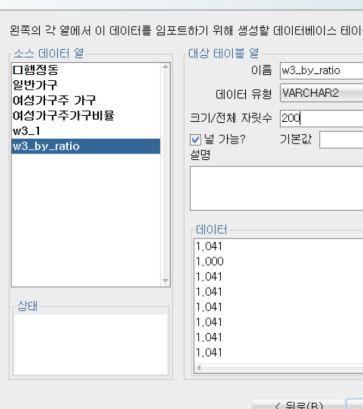

# *과정 in ORACLE 11g

### ○ 정규화를 하기위해서 파이썬과 엑셀에서 데이터타입을 변경하여 진행하고자 하였으나 알수없는 error에 결국 테이블을 oracle로 불러와서 데이터타입을 변환할 예정이다.

- 데이터를 불러올 때 모든 데이터는 varchar2 타입이다.

- 데이터안에 ,는 문자로 받아들여 데이터타입 변경이 불가능한 시점이다. 
- 그리하여 우선 콤마를 제거한다. 10,000 라면 10000으로 변경하여 저장 후 수치형으로 변환한다. 쿼리는 신중하게 다루기 위해 to_number(to_char(values,99999))형식으로 진행하지 않았다.
- 최종 쿼리 생성
- 데이터타입 확인!
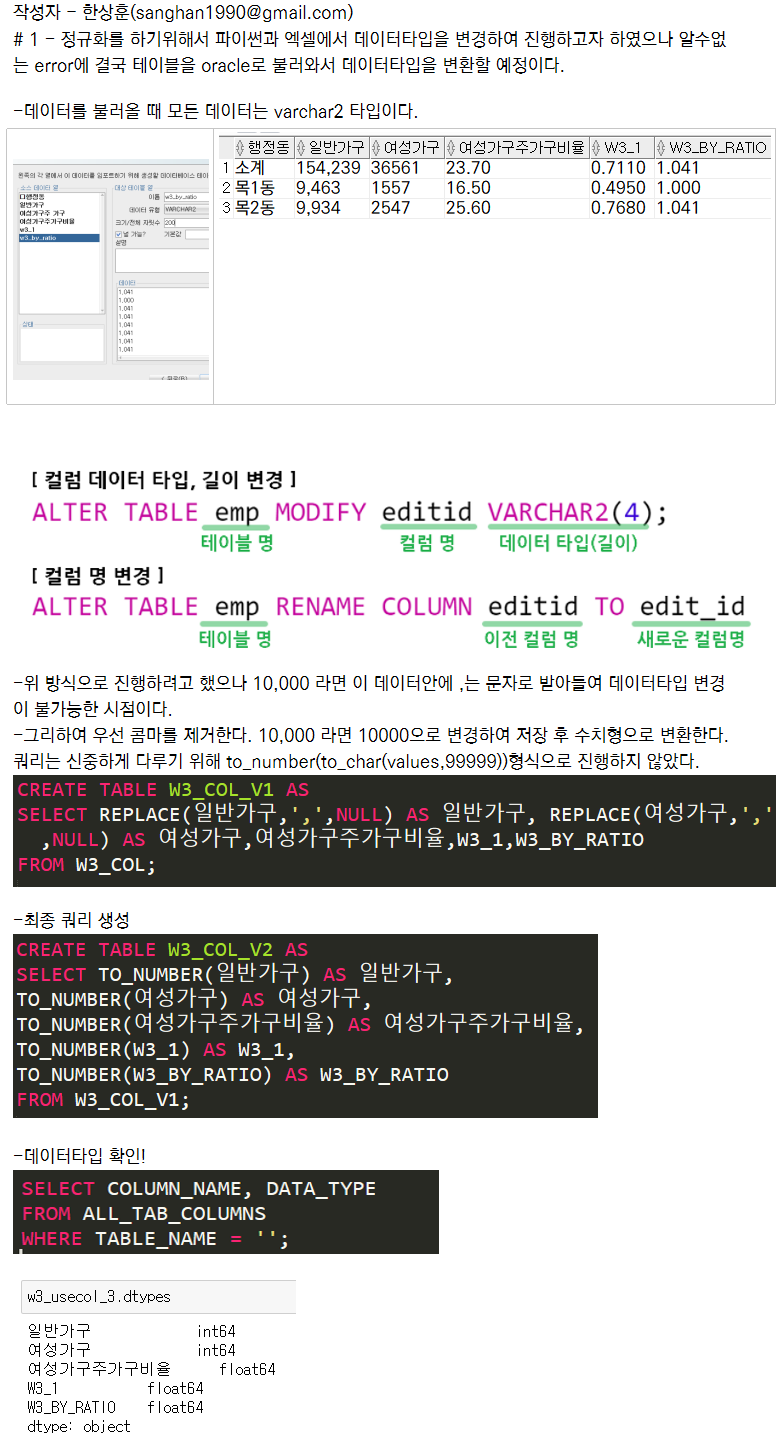

In [251]:
# read csv
# 참고로 utf_8로 우선 저장하고 불러오는게 여러모로 편하다. 
w3_usecol_3 = pd.read_csv('1215_w3_2.csv')

In [252]:
w3_usecol_3.dtypes

행정동             object
일반가구             int64
여성가구             int64
여성가구주가구비율      float64
W3_1           float64
W3_BY_RATIO    float64
dtype: object

In [253]:
df1_w3 = pd.DataFrame(w3_usecol_3.loc[:,'행정동'],columns=['행정동'])

In [259]:
df2_w3 = pd.DataFrame(mnscaler.fit_transform(w3_usecol_3.loc[ : ,'일반가구':'여성가구']), columns = ['일반가구_ratio','여성가구_ratio'])

# 성공 !

In [262]:
df2_w3[1:4]

,일반가구_ratio,여성가구_ratio
1,0.033970,0.013805
2,0.037113,0.041697
3,0.020645,0.031414


### concat 후 merge

In [263]:
w3_scaling = pd.concat([df1_w3,df2_w3],axis=1)

In [265]:
w3_scaling[1:4]

,행정동,일반가구_ratio,여성가구_ratio
1,목1동,0.033970,0.013805
2,목2동,0.037113,0.041697
3,목3동,0.020645,0.031414


In [268]:
w3_merged = pd.merge(w3_usecol,w3_scaling,on = ['행정동'])

In [272]:
w3_merged[1:19]

,행정동,일반가구,여성가구주 가구,여성가구주가구비율,w3_1,w3_by_ratio,일반가구_ratio,여성가구_ratio
1,목1동,"9,463","1,557",16.5,0.495,1.000,0.033970,0.013805
2,목2동,"9,934","2,547",25.6,0.768,1.041,0.037113,0.041697
3,목3동,"7,466","2,182",29.2,0.876,1.041,0.020645,0.031414
4,목4동,"8,445","2,008",23.8,0.714,1.041,0.027177,0.026512
5,신월1동,"8,574","2,351",27.4,0.822,1.041,0.028038,0.036175
6,신월2동,"6,418","1,574",24.5,0.735,1.041,0.013652,0.014284
7,신월3동,"6,649","1,942",29.2,0.876,1.041,0.015193,0.024652
8,신월4동,"5,636","1,132",20.1,0.603,1.000,0.008434,0.001831
9,신월5동,"5,063","1,343",26.5,0.795,1.041,0.004611,0.007776
10,신월6동,"4,372","1,067",24.4,0.732,1.041,0.000000,0.000000


행정동             object
일반가구            object
여성가구주 가구        object
여성가구주가구비율      float64
w3_1           float64
w3_by_ratio    float64
dtype: object